Loading metadata and image paths...
Initializing data generators...
Building VGG16 model...
Training the model...


c:\Users\USER\anaconda3\envs\myenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5991 - auc: 0.5814 - loss: 0.6661

1151/1151 ━━━━━━━━━━━━━━━━━━━━ 3527s 3s/step - accuracy: 0.5991 - auc: 0.5814 - loss: 0.6661 - val_accuracy: 0.6059 - val_auc: 0.6825 - val_loss: 0.6611
Epoch 2/5
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6489 - auc: 0.6825 - loss: 0.6268

1151/1151 ━━━━━━━━━━━━━━━━━━━━ 4164s 4s/step - accuracy: 0.6489 - auc: 0.6825 - loss: 0.6268 - val_accuracy: 0.6343 - val_auc: 0.7082 - val_loss: 0.6410
Epoch 3/5
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6633 - auc: 0.7022 - loss: 0.6125

1151/1151 ━━━━━━━━━━━━━━━━━━━━ 3388s 3s/step - accuracy: 0.6633 - auc: 0.7023 - loss: 0.6125 - val_accuracy: 0.6512 - val_auc: 0.7214 - val_loss: 0.6260
Epoch 4/5
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6769 - auc: 0.7147 - loss: 0.6021

1151/1151 ━━━━━━━━━━━━━━━━━━━━ 3733s 3s/step - accuracy: 0.6769 - auc: 0.7147 - loss: 0.6021 - val_accuracy: 0.6600 - val_auc: 0.7282 - val_loss: 0.6154
Epoch 5/5
1151/1151 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6858 - auc: 0.7250 - loss: 0.5942

1151/1151 ━━━━━━━━━━━━━━━━━━━━ 4181s 4s/step - accuracy: 0.6858 - auc: 0.7250 - loss: 0.5942 - val_accuracy: 0.6559 - val_auc: 0.7351 - val_loss: 0.6219
Evaluating on validation data...
100/100 ━━━━━━━━━━━━━━━━━━━━ 686s 7s/step - accuracy: 0.6459 - auc: 0.7513 - loss: 0.6329

Validation Loss: 0.6219, Accuracy: 0.6559, AUC: 0.7351


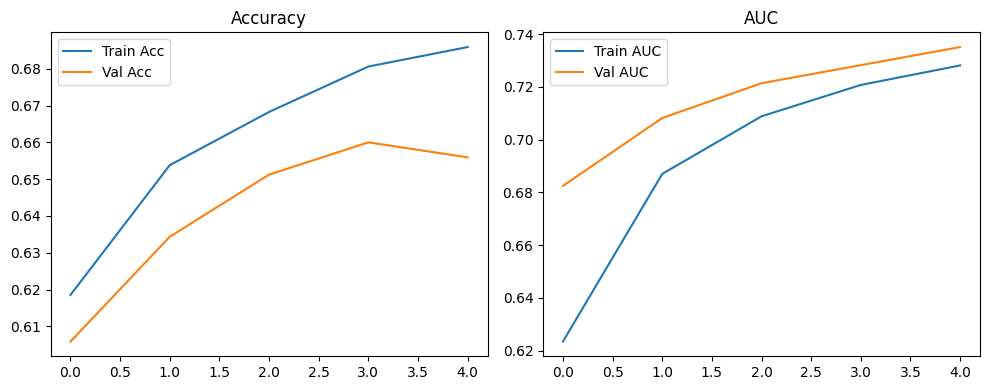

In [ ]:
"""
VGG16 Binary Classifier: Fracture vs Normal
===========================================

This script:
- Loads .npy enhanced image data from train/val folders using metadata
- Builds a VGG16 model with a custom classifier head
- Trains the model on the training set and evaluates on the validation set
"""

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

# CONFIG
CONFIG = {
    'data': {
        'train_dir': r'D:\collage project\fracture detection comp vision\fracture_detection_computer_vision\src\components\data\processed\train',
        'val_dir': r'D:\collage project\fracture detection comp vision\fracture_detection_computer_vision\src\components\data\processed\valid',
        'metadata_path': r'D:\collage project\fracture detection comp vision\fracture_detection_computer_vision\src\components\data\processed\processed_metadata.csv',
        'image_size': (224,224),

        'batch_size': 32,
    },
    'hyperparameters': {
        'learning_rate': [1e-4, 1e-5],
        'dropout_rate': [0.3, 0.5],
        'dense_units': [128, 256],
    },
    'training': {
        'epochs': 5
    }
}


class NPYDataGenerator(tf.keras.utils.Sequence):
    """Custom generator to load .npy image data in batches"""

    def __init__(self, paths, labels, batch_size=32, shuffle=True):
        self.paths = paths
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Total number of batches per epoch"""
        return int(np.ceil(len(self.paths) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""
        batch_paths = self.paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [np.load(p) for p in batch_paths]
        return np.array(batch_images), np.array(batch_labels)

    def on_epoch_end(self):
        """Shuffle data after each epoch"""
        if self.shuffle:
            idx = np.arange(len(self.paths))
            np.random.shuffle(idx)
            self.paths = self.paths[idx]
            self.labels = self.labels[idx]


def build_vgg16_model(learning_rate=1e-4, dropout_rate=0.5, dense_units=256):
    """Build VGG16 model with a custom classification head for binary output"""
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(*CONFIG['data']['image_size'], 3))
    for layer in base_model.layers:
        layer.trainable = False  # Freeze convolutional base

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(1, activation='sigmoid')(x)  # Binary classification

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
    return model


def load_metadata():
    """Load metadata CSV and return paths + labels for train/val"""
    df = pd.read_csv(CONFIG['data']['metadata_path'])

    # Filter for train/val based on directory
    train_df = df[df['path'].str.contains('train')]
    val_df = df[df['path'].str.contains('valid')]

    return train_df['path'].values, train_df['label'].values, val_df['path'].values, val_df['label'].values


def train_and_evaluate():
    """Train VGG16 model and evaluate performance on validation set"""
    print("Loading metadata and image paths...")
    X_train, y_train, X_val, y_val = load_metadata()

    print("Initializing data generators...")
    train_gen = NPYDataGenerator(X_train, y_train, batch_size=CONFIG['data']['batch_size'])
    val_gen = NPYDataGenerator(X_val, y_val, batch_size=CONFIG['data']['batch_size'], shuffle=False)

    print("Building VGG16 model...")
    model = build_vgg16_model(
        learning_rate=CONFIG['hyperparameters']['learning_rate'][0],
        dropout_rate=CONFIG['hyperparameters']['dropout_rate'][0],
        dense_units=CONFIG['hyperparameters']['dense_units'][1]
    )

    callbacks = [
        EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True),
        ModelCheckpoint('vgg16_fracture_model.h5', monitor='val_auc', save_best_only=True, mode='max')
    ]

    print("Training the model...")
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=CONFIG['training']['epochs'],
        callbacks=callbacks
    )

    print("Evaluating on validation data...")
    loss, acc, auc = model.evaluate(val_gen)
    print(f"\nValidation Loss: {loss:.4f}, Accuracy: {acc:.4f}, AUC: {auc:.4f}")

    # Plot training history
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Val AUC')
    plt.title("AUC")
    plt.legend()

    plt.tight_layout()
    plt.savefig("training_metrics.png")
    plt.show()


if __name__ == '__main__':
    train_and_evaluate()


In [5]:
from tensorflow.keras.models import load_model

# Load the trained model from saved checkpoint
model = load_model('vgg16_fracture_model.h5')

# Display the summary
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,275 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 2 (12.00 B)